In [5]:
!pip install pandas bertopic datamapplot==0.3.0 kaleido numpy==1.26.4 pandas==2.2.2 "scipy>=1.7.0,<1.14.0" "toolz>=0.11,<1.0" dask==2024.8.0 optuna scikit-optimize

In [6]:
from bertopic import BERTopic
from umap import UMAP
from hdbscan import HDBSCAN
from bertopic.vectorizers import ClassTfidfTransformer
import pandas as pd
from skopt import gp_minimize
from skopt.space import Integer, Real, Categorical
from sklearn.feature_extraction.text import CountVectorizer
from bertopic.representation import KeyBERTInspired

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Load the data**

In [8]:
data = pd.read_csv('/content/drive/MyDrive/AI Landscape Collaboration/Colab Notebooks/As_final_final_sample.csv', index_col = 0)

data = data[['Abstract', 'DOI', 'Cited by', 'Publication Year']]
data

,Abstract,DOI,Cited by,Publication Year
2635,"For employees, work involves taking breaks as ...",10.4018/JOEUC.329596,1,2023
1864,The term 'artificial intelligence' (AI) refers...,10.1109/ICONSTEM60960.2024.10568724,0,2024
4681,This study aims to explore how firms' innovati...,10.1504/IJTM.2020.112122,5,2020
2308,This research aims to investigate the acceptan...,10.4018/IJEBR.323796,0,2023
1704,Generative AI appears poised to transform whit...,10.1145/3630106.3658987,0,2024
...,...,...,...,...
2451,"Since the introduction of ChatGPT, the leading...",10.1016/j.jbusres.2024.114720,2,2024
2713,IBM has deployed its Predictive Analytics for ...,10.1287/INTE.2020.1064,1,2021
119,Natural resources have long been considered a ...,10.1016/j.resourpol.2024.104831,0,2024
4419,Purpose: This study aims to explore the role t...,10.1108/IJRDM-12-2022-0493,7,2023


**Set up the topic model**

In [9]:
# Define docs

documents = data['Abstract']
documents = documents.reset_index(drop=True)
documents = documents.tolist()
documents = [str(doc) for doc in documents if isinstance(doc, str)]

In [10]:
# Get embeddings

from sentence_transformers import SentenceTransformer
import numpy as np

embedding_model = SentenceTransformer("all-roberta-large-v1")
embeddings = embedding_model.encode(documents, show_progress_bar=True)
embeddings = embeddings.astype(np.float64)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/9.89k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/650 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/328 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/191 [00:00<?, ?B/s]

Batches:   0%|          | 0/113 [00:00<?, ?it/s]

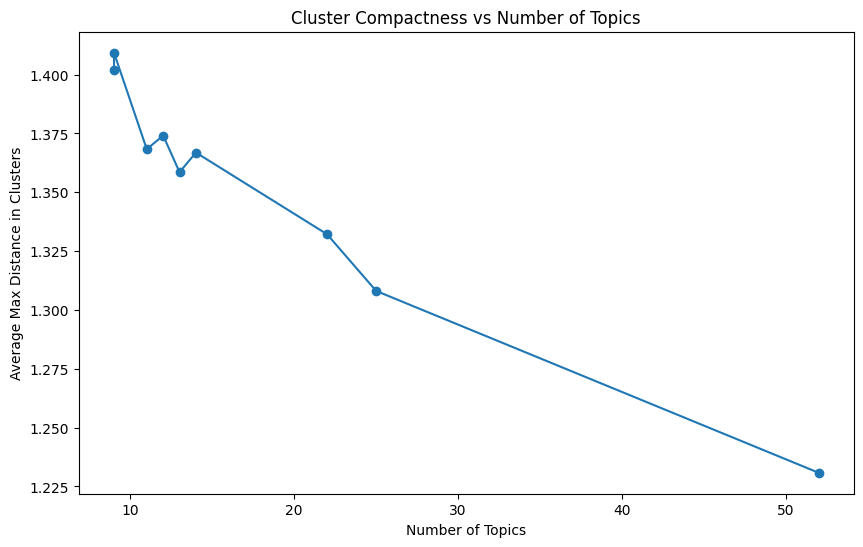

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import pairwise_distances

# Define your parameter range for min_cluster_size
min_cluster_sizes = range(10, 100, 10)
max_distances = []
num_topics = []

for min_cluster_size in min_cluster_sizes:
    # Update the HDBSCAN model with the new min_cluster_size
    hdbscan_model = HDBSCAN(min_cluster_size=min_cluster_size, metric='euclidean',
                            cluster_selection_method='eom', prediction_data=True)

    # Initialise the BERTopic model
    topic_model = BERTopic(
        embedding_model=None,
        umap_model=UMAP(n_neighbors=15, n_components=5, metric='cosine', random_state=42),
        hdbscan_model=hdbscan_model,
        vectorizer_model=CountVectorizer(stop_words="english")
    )

    # Fit the model on your data
    topics, probs = topic_model.fit_transform(documents, embeddings)

    # Calculate maximum distance for each cluster
    cluster_distances = []
    for cluster in set(topics):
        if cluster == -1:  # Skip the outliers
            continue
        cluster_points = embeddings[np.array(topics) == cluster]
        if len(cluster_points) > 1:  # Avoid single-point clusters
            max_distance = pairwise_distances(cluster_points).max()
            cluster_distances.append(max_distance)

    # Record metrics
    max_distances.append(np.mean(cluster_distances))  # Average max intra-cluster distance
    num_topics.append(len(set(topics)) - (1 if -1 in topics else 0))  # Number of topics

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(num_topics, max_distances, marker='o')
plt.xlabel("Number of Topics")
plt.ylabel("Average Max Distance in Clusters")
plt.title("Cluster Compactness vs Number of Topics")
plt.show()


In [12]:
## Min cluster size = 30 seems like the best choice here.

# Update the HDBSCAN model with the new min_cluster_size
hdbscan_model = HDBSCAN(min_cluster_size=30, metric='euclidean',
                        cluster_selection_method='eom', prediction_data=True)

# Initialise the BERTopic model
topic_model = BERTopic(
    embedding_model=None,
    umap_model=UMAP(n_neighbors=15, n_components=5, metric='cosine', random_state=42),
    hdbscan_model=hdbscan_model,
    vectorizer_model=CountVectorizer(stop_words="english")
)

# Fit the model on your data
topics, probs = topic_model.fit_transform(documents, embeddings)

# Calculate maximum distance for each cluster
cluster_distances = []
for cluster in set(topics):
    if cluster == -1:  # Skip the outliers
        continue
    cluster_points = embeddings[np.array(topics) == cluster]
    if len(cluster_points) > 1:  # Avoid single-point clusters
        max_distance = pairwise_distances(cluster_points).max()
        cluster_distances.append(max_distance)

# Record metrics
print(np.mean(cluster_distances))  # Average max intra-cluster distance
print(len(set(topics)) - (1 if -1 in topics else 0))  # Number of topics

1.3321705399288715
22


In [13]:
topic_df = topic_model.get_topic_info()
topic_df.to_csv('/content/drive/MyDrive/AI Landscape Collaboration/Colab Notebooks/topics_new_test.csv')
topic_df

,Topic,Count,Name,Representation,Representative_Docs
0,-1,1189,-1_ai_study_intelligence_artificial,"[ai, study, intelligence, artificial, data, re...","[Emerging technologies, such as artificial int..."
1,0,208,0_ai_business_innovation_adoption,"[ai, business, innovation, adoption, value, or...",[Artificial intelligence (AI) has been alterin...
2,1,199,1_manufacturing_production_40_industry,"[manufacturing, production, 40, industry, tech...",[Employing recent research results covering In...
3,2,196,2_hr_hrm_human_management,"[hr, hrm, human, management, ai, employee, rec...",[Using an in-depth qualitative case study desi...
4,3,184,3_financial_banking_banks_services,"[financial, banking, banks, services, ai, inte...",[Purpose: This study finds the current and fut...
5,4,181,4_labor_employment_automation_labour,"[labor, employment, automation, labour, worker...",[As the largest industry that absorbs labor fr...
6,5,170,5_supply_chain_resilience_logistics,"[supply, chain, resilience, logistics, managem...",[The escalating complexity of dynamic supply c...
7,6,146,6_chatgpt_generative_language_llms,"[chatgpt, generative, language, llms, students...",[The study addresses the potential benefits fo...
8,7,146,7_tourism_service_hospitality_robots,"[tourism, service, hospitality, robots, hotel,...",[This research proposes a model that identifie...
9,8,140,8_healthcare_medical_health_ai,"[healthcare, medical, health, ai, patient, car...",[Artificial intelligence (AI) in healthcare is...


**Label topics and display counts**

In [14]:
custom_topic_labels = {
    -1: "General",
    0: "Business and Innovation",
    1: "Manufacturing",
    2: "HR and Management",
    3: "Finance and Banking",
    4: "Automation and the Labour Market",
    5: "Supply Chains",
    6: "Generative AI",
    7: "Tourism and Hospitality",
    8: "Healthcare and Medicine",
    9: "Innovation and Patents",
    10: "Energy and Green Development",
    11: "Accounting and Auditing",
    12: "Customer Service Chatbots",
    13: "Decision-Making and Ethics",
    14: "ESG and Corporate Strategy",
    15: "B2B Marketing and CRM",
    16: "Digital Shopping",
    17: "Construction",
    18: "Employee Awareness",
    19: "Governance and Regulation",
    20: "Corporate Disclosure",
    21: "Pricing and Competition"
}

topic_model.set_topic_labels(custom_topic_labels)

In [15]:
papers_topics = pd.DataFrame({'Paper': documents, 'Topic': topics, 'Probability': probs})
papers_topics = papers_topics.rename(columns = {"Paper" : "Abstract"})
papers_topics = papers_topics.merge(data, on = "Abstract", how = "inner")
papers_topics.to_csv('/content/drive/MyDrive/AI Landscape Collaboration/Colab Notebooks/papers_topics.csv')
papers_topics

,Abstract,Topic,Probability,DOI,Cited by,Publication Year
0,"For employees, work involves taking breaks as ...",-1,0.000000,10.4018/JOEUC.329596,1,2023
1,The term 'artificial intelligence' (AI) refers...,-1,0.000000,10.1109/ICONSTEM60960.2024.10568724,0,2024
2,This study aims to explore how firms' innovati...,9,0.830921,10.1504/IJTM.2020.112122,5,2020
3,This research aims to investigate the acceptan...,-1,0.000000,10.4018/IJEBR.323796,0,2023
4,Generative AI appears poised to transform whit...,6,0.784905,10.1145/3630106.3658987,0,2024
...,...,...,...,...,...,...
3594,"Since the introduction of ChatGPT, the leading...",6,0.924909,10.1016/j.jbusres.2024.114720,2,2024
3595,IBM has deployed its Predictive Analytics for ...,-1,0.000000,10.1287/INTE.2020.1064,1,2021
3596,Natural resources have long been considered a ...,-1,0.000000,10.1016/j.resourpol.2024.104831,0,2024
3597,Purpose: This study aims to explore the role t...,16,1.000000,10.1108/IJRDM-12-2022-0493,7,2023


In [16]:
topics_citations_sum = papers_topics[['Cited by', 'Topic']].groupby('Topic').sum().reset_index().rename(columns = {'Cited by':'sum_citations'})
topics_citations_average = papers_topics[['Cited by', 'Topic']].groupby('Topic').mean().reset_index().rename(columns = {'Cited by':'mean_citations'})
topics_citations_median = papers_topics[['Cited by', 'Topic']].groupby('Topic').median().reset_index().rename(columns = {'Cited by':'med_citations'})
topics_citations_max = papers_topics[['Cited by', 'Topic']].groupby('Topic').max().reset_index().rename(columns = {'Cited by':'max_citations'})

topics_citations = pd.merge(topics_citations_sum, topics_citations_average, on = 'Topic', how = 'inner')
topics_citations = pd.merge(topics_citations, topics_citations_median, on = 'Topic', how = 'inner')
topics_citations = pd.merge(topics_citations, topics_citations_max, on = 'Topic', how = 'inner')

topics_citations.sort_values('mean_citations', ascending=False)
# topics_citations.to_csv('/content/drive/MyDrive/AI Landscape Collaboration/Colab Notebooks/topics_citations.csv')

,Topic,sum_citations,mean_citations,med_citations,max_citations
16,15,3071,53.877193,2.0,897
8,7,5832,39.945205,9.0,550
14,13,2483,36.514706,6.0,368
13,12,3101,32.642105,8.0,530
17,16,1345,26.900000,6.5,405
1,0,5047,24.264423,4.0,402
6,5,3602,21.188235,4.0,320
0,-1,25146,21.148865,3.0,1459
2,1,4032,20.261307,4.0,308
7,6,2898,19.849315,2.0,1079


**Extract labour questions**

In [17]:
supply_chains = papers_topics[papers_topics['Topic'] == 0]
supply_chains

,Abstract,Topic,Probability,DOI,Cited by,Publication Year
20,While many knowledge workers may fear that the...,0,0.883649,10.1002/ev.20562,9,2023
26,Artificial Intelligence (AI) provides organiza...,0,0.938065,10.1007/978-3-030-86797-3_12,2,2021
47,"Recently, with the advancement of artificial i...",0,0.815467,10.1016/j.tre.2024.103424,1,2024
72,Companies collecting and creating valuable ins...,0,0.895622,10.1109/IEEM45057.2020.9309824,11,2020
83,Development of small and medium enterprises (S...,0,0.868863,10.1016/j.indmarman.2021.09.003,66,2021
...,...,...,...,...,...,...
3523,"Purpose: In the past decade, in the space indu...",0,0.873024,10.1108/MBE-12-2020-0161,12,2022
3568,This article provides an integrative research ...,0,0.929727,10.1109/ICIPTM54933.2022.9754046,3,2022
3570,Artificial Intelligence (AI) is increasingly a...,0,1.000000,10.1016/j.technovation.2022.102623,95,2023
3572,Driven by the growing availability and accessi...,0,0.813266,10.1007/978-3-031-52120-1_2,0,2024


In [18]:
## WRITE PROMPT

prompt = "You are an academic expert in economics, finance, management and innovation studies. You are provided with abstracts from academic papers. Your goal is to carefully review each abstract to identify the main research question. Then, summarize this research question in less than 50 words."

example1 = """The environmental effect of operating activities in the manufacturing industry is crucial to the sustainable development of the economy and society. Since we have entered the era of information explosion, the artificial intelligence has been involved to address the environmental problems caused by daily operations. This study examines the complex relation between artificial intelligence application and corporate environmental investment. The results show that: (1) AI application have a direct and positive impact on corporate environmental investment; (2) Managerial myopia plays a negative moderating role, inhibiting the positive effect of AI application on corporate environmental investment; (3) Companies' pollution emission mediates the relationship between AI application and corporate environmental investment. When reduced by AI application, a lower pollution emission will trigger a larger scale of corporate environmental investment; (4) Compared with under-valued companies and those in the Western region, AI application has a greater positive impact on the environmental investment of the over-valued companies and those in the East-Central region. By verifying the relationship between artificial intelligence applications and manufacturing enterprise investment, this study has a positive impact on promoting green innovation in the manufacturing industry and is of great significance for sustainable development strategies."""

output1 = "What is the relationship between artificial intelligence application and corporate environmental investment?"

In [19]:
# ## PROMPT GPT-4o mini

# from openai import OpenAI
# import time
# import logging
# from tqdm import tqdm
# import re
# from google.colab import userdata

# # set up logging
# logging.basicConfig(level = logging.INFO)

# # set up api
# api_key = userdata.get("OPENAI_API_KEY")
# client = OpenAI(api_key = api_key)

# # set up data dict
# data_dict = {
#         'Abstract': [],
#         'Question': []
#     }

# # loop through abstracts
# for index, row in tqdm(supply_chains.iterrows(), desc = 'Processing abstracts'):
#     response = client.chat.completions.create(
#         model="gpt-4o-mini",
#         max_tokens=200,
#         temperature=0,
#         seed=2345,
#         messages=[
#             {"role": "system", "content": prompt},
#             {"role": "user", "content": example1},
#             {"role": "assistant", "content": output1},
#             {"role": "user", "content": row['Abstract']}
#         ]
#     )

#     # store data in df
#     data_dict['Abstract'].append(row['Abstract'])
#     message = response.choices[0].message.content
#     data_dict['Question'].append(message)

# # Display the DataFrame
# supply_chains_questions = pd.DataFrame(data_dict)
# supply_chains_questions

# supply_chains_questions.to_csv('/content/drive/MyDrive/Colab Notebooks/supply_chains.csv')

**Visualisations**

In [23]:
# Add labels

topic_df['Label'] = topic_df['Topic'].apply(lambda x: custom_topic_labels[x])
topic_df

,Topic,Count,Name,Representation,Representative_Docs,Label
0,-1,1189,-1_ai_study_intelligence_artificial,"[ai, study, intelligence, artificial, data, re...","[Emerging technologies, such as artificial int...",General
1,0,208,0_ai_business_innovation_adoption,"[ai, business, innovation, adoption, value, or...",[Artificial intelligence (AI) has been alterin...,Business and Innovation
2,1,199,1_manufacturing_production_40_industry,"[manufacturing, production, 40, industry, tech...",[Employing recent research results covering In...,Manufacturing
3,2,196,2_hr_hrm_human_management,"[hr, hrm, human, management, ai, employee, rec...",[Using an in-depth qualitative case study desi...,HR and Management
4,3,184,3_financial_banking_banks_services,"[financial, banking, banks, services, ai, inte...",[Purpose: This study finds the current and fut...,Finance and Banking
5,4,181,4_labor_employment_automation_labour,"[labor, employment, automation, labour, worker...",[As the largest industry that absorbs labor fr...,Automation and the Labour Market
6,5,170,5_supply_chain_resilience_logistics,"[supply, chain, resilience, logistics, managem...",[The escalating complexity of dynamic supply c...,Supply Chains
7,6,146,6_chatgpt_generative_language_llms,"[chatgpt, generative, language, llms, students...",[The study addresses the potential benefits fo...,Generative AI
8,7,146,7_tourism_service_hospitality_robots,"[tourism, service, hospitality, robots, hotel,...",[This research proposes a model that identifie...,Tourism and Hospitality
9,8,140,8_healthcare_medical_health_ai,"[healthcare, medical, health, ai, patient, car...",[Artificial intelligence (AI) in healthcare is...,Healthcare and Medicine


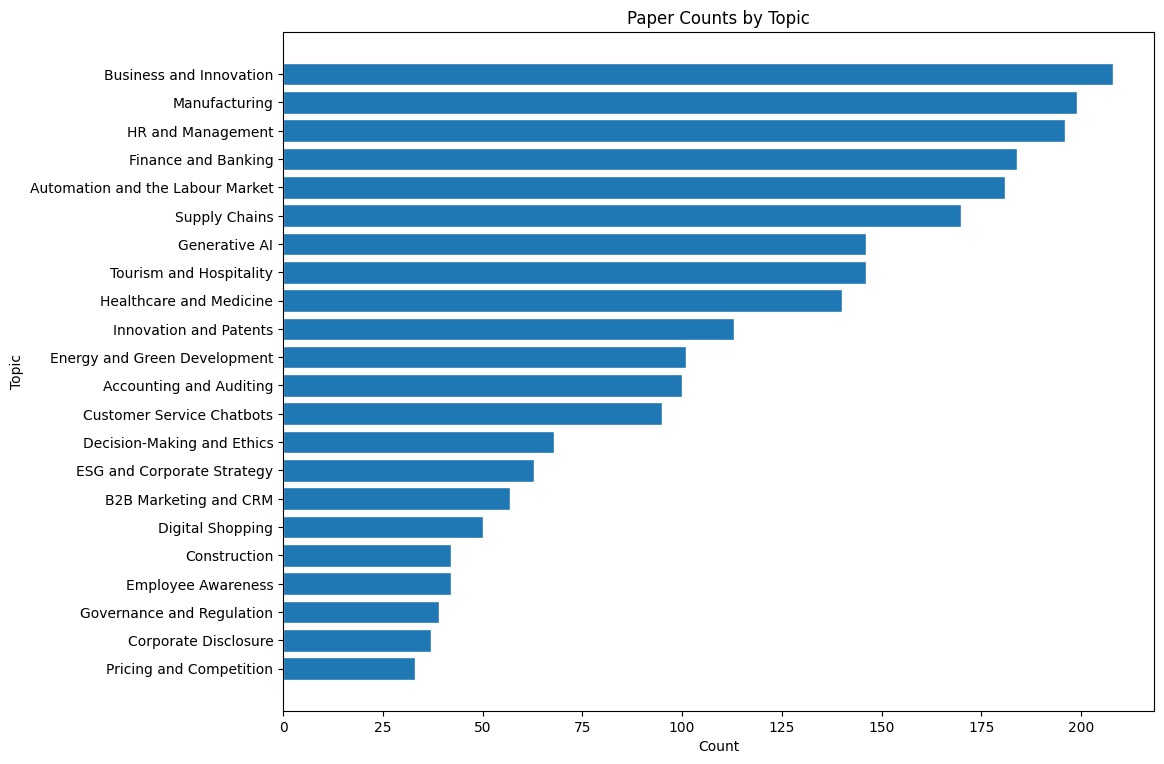

In [30]:
# Paper counts by topic

# Filter out the '-1' topic (if needed)
proper_topics = topic_df[topic_df['Topic'] != -1]

# Creating the bar chart
plt.figure(figsize=(12, 8))
plt.barh(proper_topics['Label'], proper_topics['Count'], edgecolor="white")
plt.xlabel("Count")
plt.ylabel("Topic")
plt.title("Paper Counts by Topic")
plt.gca().invert_yaxis()  # Invert y-axis for better readability
plt.tight_layout(pad=2)

# Saving the figure to a file
file_path = "/content/drive/MyDrive/AI Landscape Collaboration/Colab Notebooks/images/counts.pdf"
plt.savefig(file_path, format="pdf", bbox_inches="tight")
plt.show()

In [95]:
fig = topic_model.visualize_barchart(topics = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], custom_labels = True)
fig.show()
fig.write_image("/content/drive/MyDrive/AI Landscape Collaboration/Colab Notebooks/images/bars.pdf")

In [57]:
fig = topic_model.visualize_topics(custom_labels = True)
fig.show()
fig.write_image("/content/drive/MyDrive/AI Landscape Collaboration/Colab Notebooks/images/intertopic_distances.pdf")

In [96]:
fig = topic_model.visualize_heatmap(topics = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], custom_labels = True, width = 800, height = 600)
fig.show()
fig.write_image("/content/drive/MyDrive/AI Landscape Collaboration/Colab Notebooks/images/similarity_matrix.pdf")

In [97]:
import plotly.graph_objects as go  # Import plotly's graph objects
from typing import List, Union

def visualize_topics_over_time(
    topic_model,
    topics_over_time: pd.DataFrame,
    top_n_topics: int = None,
    topics: List[int] = None,
    normalize_frequency: bool = False,
    custom_labels: Union[bool, str] = False,
    title: str = "<b>Topics over Time</b>",
    width: int = 1250,
    height: int = 450,
) -> go.Figure:
    """Visualize topics over time with custom line styles."""

    colors = [
        "#E69F00",
        "#56B4E9",
        "#009E73",
        "#F0E442",
        "#D55E00",
        "#0072B2",
        "#CC79A7",
    ]

    # Define custom dash patterns for each topic
    dash_styles = ['solid', 'dash', 'dot', 'dashdot', 'solid', 'dash', 'dot']

    # Select topics based on top_n and topics args
    freq_df = topic_model.get_topic_freq()
    freq_df = freq_df.loc[freq_df.Topic != -1, :]
    if topics is not None:
        selected_topics = list(topics)
    elif top_n_topics is not None:
        selected_topics = sorted(freq_df.Topic.to_list()[:top_n_topics])
    else:
        selected_topics = sorted(freq_df.Topic.to_list())

    # Prepare data
    if isinstance(custom_labels, str):
        topic_names = [[[str(topic), None]] + topic_model.topic_aspects_[custom_labels][topic] for topic in topics]
        topic_names = ["_".join([label[0] for label in labels[:4]]) for labels in topic_names]
        topic_names = [label if len(label) < 30 else label[:27] + "..." for label in topic_names]
        topic_names = {key: topic_names[index] for index, key in enumerate(topic_model.topic_labels_.keys())}
    elif topic_model.custom_labels_ is not None and custom_labels:
        topic_names = {
            key: topic_model.custom_labels_[key + topic_model._outliers] for key, _ in topic_model.topic_labels_.items()
        }
    else:
        topic_names = {
            key: value[:40] + "..." if len(value) > 40 else value for key, value in topic_model.topic_labels_.items()
        }
    topics_over_time["Name"] = topics_over_time.Topic.map(topic_names)
    data = topics_over_time.loc[topics_over_time.Topic.isin(selected_topics), :].sort_values(["Topic", "Timestamp"])

    # Add traces
    fig = go.Figure()
    for index, topic in enumerate(data.Topic.unique()):  # Loop through each unique topic
        trace_data = data.loc[data.Topic == topic, :]  # Select data for the current topic
        topic_name = trace_data.Name.values[0]  # Get the name of the current topic
        words = trace_data.Words.values  # Get the words associated with the topic
        if normalize_frequency:
            y = normalize(trace_data.Frequency.values.reshape(1, -1))[0]  # Normalize frequency if needed
        else:
            y = trace_data.Frequency  # Use raw frequency if not normalizing

        # Add trace for the current topic with a custom line style
        fig.add_trace(
            go.Scatter(
                x=trace_data.Timestamp,  # Timestamps on the x-axis
                y=y,  # Frequencies on the y-axis
                mode="lines",  # Line plot
                line=dict(
                    dash=dash_styles[index % len(dash_styles)],  # Apply different dash styles cyclically
                    width=2  # Adjust line width if needed
                ),
                marker_color=colors[index % 7],  # Cycle through predefined colors
                hoverinfo="text",  # What info to show on hover
                name=topic_name,  # Topic name
                hovertext=[f"<b>Topic {topic}</b><br>Words: {word}" for word in words],  # Hover text with topic and words
            )
        )

    # Styling of the visualization
    fig.update_xaxes(showgrid=True)
    fig.update_yaxes(showgrid=True)
    fig.update_layout(
        yaxis_title="Normalized Frequency" if normalize_frequency else "Frequency",
        title={
            "text": f"{title}",
            "y": 0.95,
            "x": 0.40,
            "xanchor": "center",
            "yanchor": "top",
            "font": dict(size=22, color="Black"),
        },
        template="simple_white",
        width=width,
        height=height,
        hoverlabel=dict(bgcolor="white", font_size=16, font_family="Rockwell"),
        legend=dict(
            title="<b>Global Topic Representation",
        ),
    )

    return fig  # Return the figure

In [ ]:
custom_topic_labels = {
    -1: "General",
    0: "Business and Innovation",
    1: "Manufacturing",
    2: "HR and Management",
    3: "Finance and Banking",
    4: "Automation and the Labour Market",
    5: "Supply Chains",
    6: "Generative AI",
    7: "Tourism and Hospitality",
    8: "Healthcare and Medicine",
    9: "Innovation and Patents",
    10: "Energy and Green Development",
    11: "Accounting and Auditing",
    12: "Customer Service Chatbots",
    13: "Decision-Making and Ethics",
    14: "ESG and Corporate Strategy",
    15: "B2B Marketing and CRM",
    16: "Digital Shopping",
    17: "Construction",
    18: "Employee Awareness",
    19: "Governance and Regulation",
    20: "Corporate Disclosure",
    21: "Pricing and Competition"
}

In [110]:
## TOPICS OVER TIME
import plotly.graph_objects as go
import matplotlib.pyplot as plt

# Prepare data
timestamps = data['Publication Year'].to_list()

# Create topics over time
topics_over_time = topic_model.topics_over_time(documents, timestamps)

# Visualise
fig = visualize_topics_over_time(
    topic_model=topic_model,
    topics_over_time=topics_over_time,
    topics= [3, 4, 6, 9],
    custom_labels=True
)

# Show the figure
fig.show()
fig.write_image("/content/drive/MyDrive/AI Landscape Collaboration/Colab Notebooks/images/gen_AI_vs_longstanding.pdf")

In [112]:
## TOPICS OVER TIME
import plotly.graph_objects as go
import matplotlib.pyplot as plt

# Prepare data
timestamps = data['Publication Year'].to_list()

# Create topics over time
topics_over_time = topic_model.topics_over_time(documents, timestamps)

# Visualise
fig = visualize_topics_over_time(
    topic_model=topic_model,
    topics_over_time=topics_over_time,
    topics= [1, 5, 10],
    custom_labels=True
)

# Show the figure
fig.show()
fig.write_image("/content/drive/MyDrive/AI Landscape Collaboration/Colab Notebooks/images/supply_chains.pdf")

In [99]:
docs_df = pd.DataFrame({'Abstract': documents})
docs_cits = docs_df.merge(data[['Abstract', 'Cited by']], on = 'Abstract', how = 'left')[['Abstract', 'Cited by']]
docs_cits

,Abstract,Cited by
0,"For employees, work involves taking breaks as ...",1
1,The term 'artificial intelligence' (AI) refers...,0
2,This study aims to explore how firms' innovati...,5
3,This research aims to investigate the acceptan...,0
4,Generative AI appears poised to transform whit...,0
...,...,...
3594,"Since the introduction of ChatGPT, the leading...",2
3595,IBM has deployed its Predictive Analytics for ...,1
3596,Natural resources have long been considered a ...,0
3597,Purpose: This study aims to explore the role t...,7


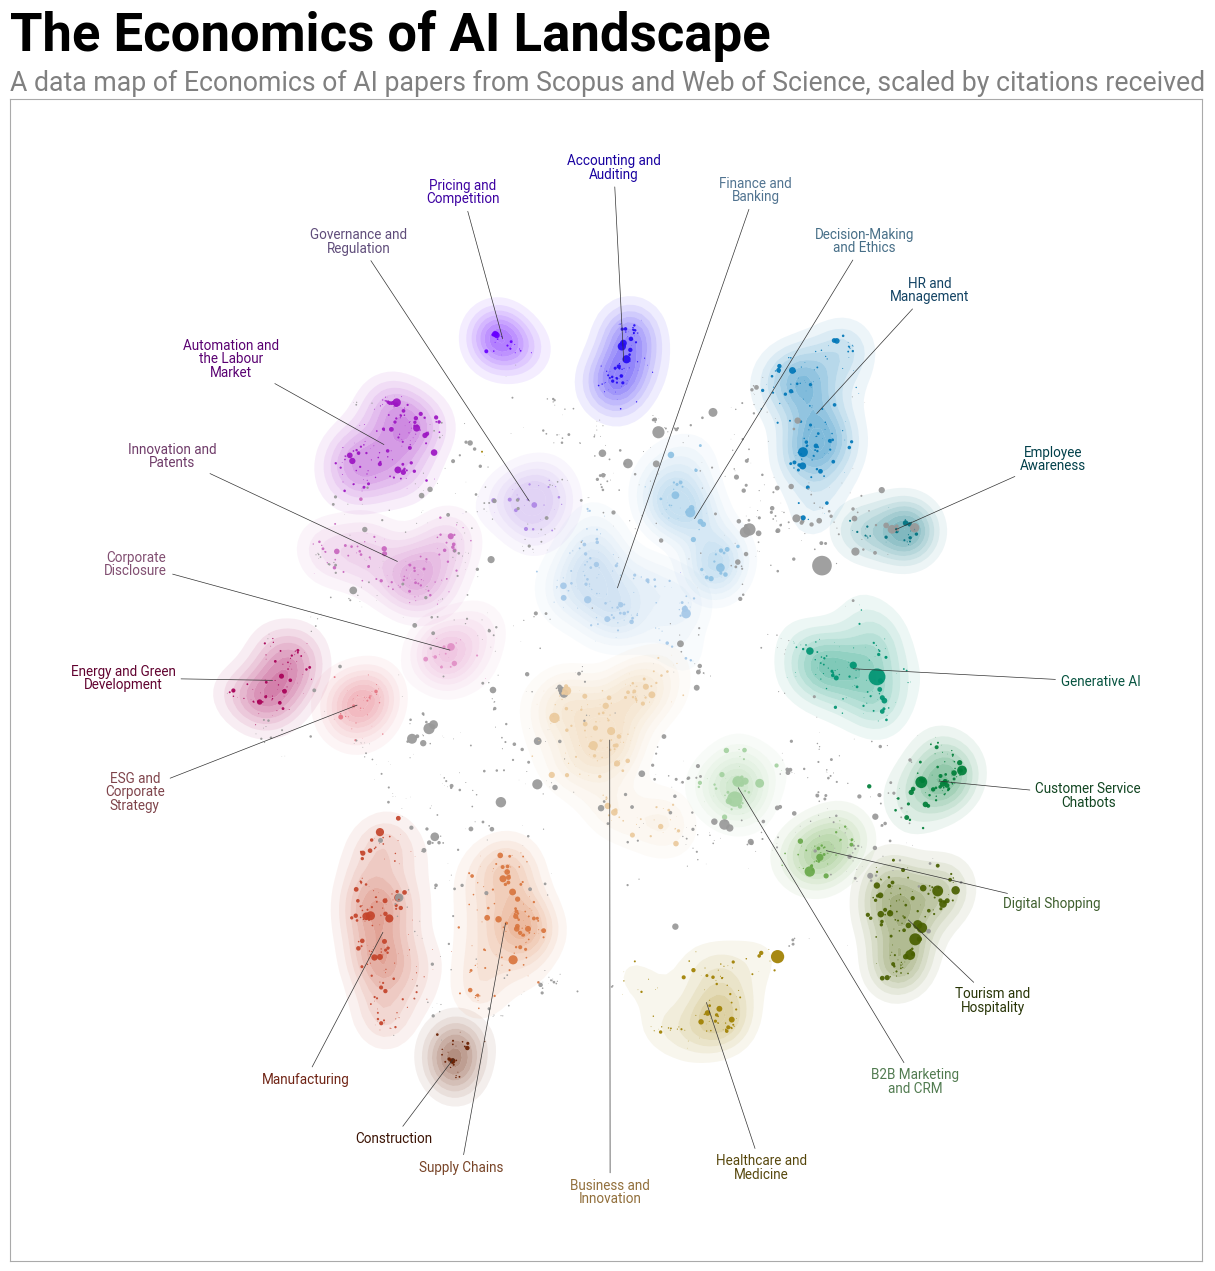

In [100]:
import plotly.io as pio
import datamapplot
import matplotlib

citations = docs_cits['Cited by'].to_list()
scaled_citations = [2*(c / max(citations)) * 100 for c in citations]
fig = topic_model.visualize_document_datamap(documents, custom_labels = True, embeddings=embeddings, point_size=scaled_citations, title="The Economics of AI Landscape", sub_title="A data map of Economics of AI papers from Scopus and Web of Science, scaled by citations received")
fig.show()
fig.savefig("/content/drive/MyDrive/AI Landscape Collaboration/Colab Notebooks/images/landscape.pdf", dpi=600, bbox_inches='tight')

In [32]:
topics_citations

,Topic,sum_citations,mean_citations,med_citations,max_citations
0,-1,25146,21.148865,3.0,1459
1,0,5047,24.264423,4.0,402
2,1,4032,20.261307,4.0,308
3,2,2970,15.153061,2.0,372
4,3,3009,16.353261,4.5,344
5,4,3368,18.607735,4.0,263
6,5,3602,21.188235,4.0,320
7,6,2898,19.849315,2.0,1079
8,7,5832,39.945205,9.0,550
9,8,2315,16.535714,3.0,664


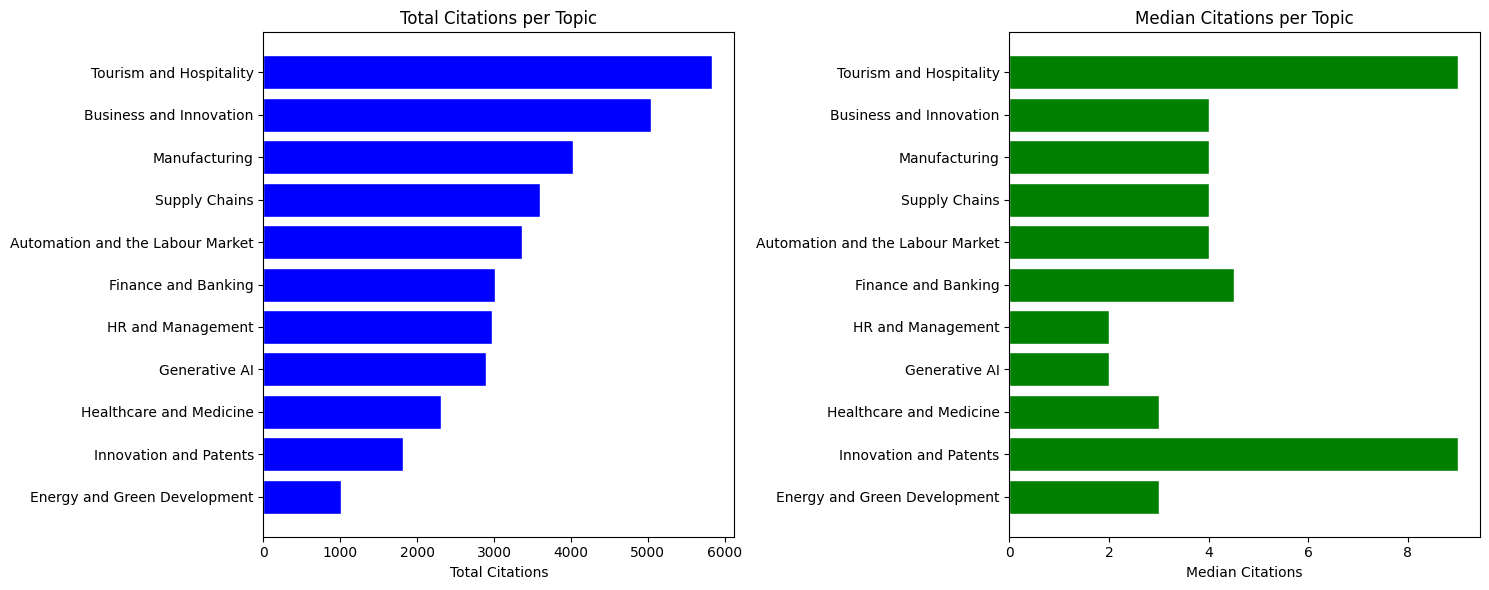

In [39]:
## Citations per topic

topics_citations_label = topics_citations.copy()
topics_citations_label['Label'] = topics_citations['Topic'].apply(lambda x: custom_topic_labels[x])
topics_citations_label = topics_citations_label[(topics_citations_label['Topic'] <= 10) & (topics_citations_label['Topic'] != -1)]
topics_citations_label = topics_citations_label.sort_values(by='sum_citations', ascending=False)

# Creating the plot with two subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Total Citations bar chart
axes[0].barh(topics_citations_label['Label'], topics_citations_label['sum_citations'], color='blue', edgecolor="white")
axes[0].set_title("Total Citations per Topic")
axes[0].set_xlabel("Total Citations")
axes[0].invert_yaxis()  # Invert y-axis for better readability

# Mean Citations bar chart
axes[1].barh(topics_citations_label['Label'], topics_citations_label['med_citations'], color='green', edgecolor="white")
axes[1].set_title("Median Citations per Topic")
axes[1].set_xlabel("Median Citations")
axes[1].invert_yaxis()  # Ensure both y-axes match

# Adjust layout and show
plt.tight_layout()
plt.show()

file_path_cits = "/content/drive/MyDrive/AI Landscape Collaboration/Colab Notebooks/images/citations_by_topic.pdf"
fig.savefig(file_path_cits, format="pdf", bbox_inches="tight")

**Extract random sample of papers for each topic**

In [ ]:
papers_topics

In [ ]:
for i in range(0, 21):
    topic_sample = papers_topics[papers_topics['Topic'] == i].sample(n=50, random_state=123)
    topic_sample.to_csv(f'/content/drive/My Drive/Colab Notebooks/topic{i}_sample.csv', index=False)

**Word embeddings**

In [ ]:
# import matplotlib.pyplot as plt
# from sentence_transformers import SentenceTransformer
# import numpy as np

# embedding_model = SentenceTransformer("all-roberta-large-v1")
# embeddings = embedding_model.encode(docs_list, show_progress_bar=True)

# # If embeddings is not a NumPy array, convert it
# if not isinstance(embeddings, np.ndarray):
#     embeddings = np.array(embeddings)

# from umap import UMAP
# umap_model = UMAP(n_neighbors=15, n_components=10, min_dist=0.0, metric='cosine')
# umap_embeddings = umap_model.fit_transform(embeddings)

# plt.figure(figsize=(10, 8))
# plt.scatter(umap_embeddings[:, 0], umap_embeddings[:, 1], s=5, alpha=0.5)
# plt.title('UMAP Projection of Embeddings')
# plt.xlabel('UMAP Dimension 1')
# plt.ylabel('UMAP Dimension 2')
# plt.show()